In [1]:
#import relevant libraries
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error

import joblib

In [2]:
#read in dataset
data = pd.read_parquet('data_files/yellow_tripdata_2022-01.parquet')
data.shape

(2463931, 19)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,2463931.0,1.707819,0.502137,1.00,1.00,2.00,2.00,6.00
passenger_count,2392428.0,1.389453,0.982969,0.00,1.00,1.00,1.00,9.00
trip_distance,2463931.0,5.372751,547.871404,0.00,1.04,1.74,3.13,306159.28
RatecodeID,2392428.0,1.415507,5.917573,1.00,1.00,1.00,1.00,99.00
PULocationID,2463931.0,166.076809,65.468057,1.00,132.00,162.00,234.00,265.00
DOLocationID,2463931.0,163.580716,70.790159,1.00,113.00,162.00,236.00,265.00
payment_type,2463931.0,1.194449,0.500178,0.00,1.00,1.00,1.00,5.00
fare_amount,2463931.0,12.946484,255.814887,-480.00,6.50,9.00,14.00,401092.32
extra,2463931.0,1.006710,1.236226,-4.50,0.00,0.50,2.50,33.50
mta_tax,2463931.0,0.491454,0.082916,-0.50,0.50,0.50,0.50,16.59


In [5]:
#feature engineering
data['trip_duration'] = data.tpep_dropoff_datetime - data.tpep_pickup_datetime #creating the duration feature
data['trip_duration'] = data.trip_duration.apply(lambda x: x.total_seconds()/60)#convert duration seconds into minutes

In [6]:
data['trip_duration'].head(2), data['trip_duration'].dtypes

(0    17.816667
 1     8.400000
 Name: trip_duration, dtype: float64,
 dtype('float64'))

In [18]:
#standard deviation of trips
data['trip_duration'].describe()

count    2.421440e+06
mean     1.267128e+01
std      8.999282e+00
min      1.000000e+00
25%      6.433333e+00
50%      1.023333e+01
75%      1.613333e+01
max      6.000000e+01
Name: trip_duration, dtype: float64

In [7]:
#identifying negative values
data['trip_duration'].describe(percentiles=[0.98,0.95])

count    2.463931e+06
mean     1.421220e+01
std      4.644531e+01
min     -3.442400e+03
50%      1.018333e+01
95%      3.193333e+01
98%      4.215000e+01
max      8.513183e+03
Name: trip_duration, dtype: float64

In [8]:
#filtering data
#data[(data['trip_duration'] >= 1) & (data['trip_duration'] <= 60)].describe().T
data = data[(data['trip_duration'] >= 1) & (data['trip_duration'] <= 60)]
data.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,2421440.0,1.700020,0.470513,1.00,1.000000,2.000000,2.000000,6.00
passenger_count,2354481.0,1.389813,0.983616,0.00,1.000000,1.000000,1.000000,9.00
trip_distance,2421440.0,5.374377,552.445809,0.00,1.060000,1.760000,3.120000,306159.28
RatecodeID,2354481.0,1.359217,5.585660,1.00,1.000000,1.000000,1.000000,99.00
PULocationID,2421440.0,166.032304,65.352711,1.00,132.000000,162.000000,234.000000,265.00
DOLocationID,2421440.0,163.625926,70.709811,1.00,113.000000,162.000000,236.000000,265.00
payment_type,2421440.0,1.189319,0.487670,0.00,1.000000,1.000000,1.000000,5.00
fare_amount,2421440.0,12.661615,257.990041,-335.00,6.500000,9.000000,13.500000,401092.32
extra,2421440.0,1.014453,1.234236,-4.50,0.000000,0.500000,2.500000,33.50
mta_tax,2421440.0,0.494062,0.070605,-0.50,0.500000,0.500000,0.500000,3.30


In [29]:
#fraction of dataset left
2421440/2463931

0.9827547930522406

<AxesSubplot: xlabel='trip_duration', ylabel='Density'>

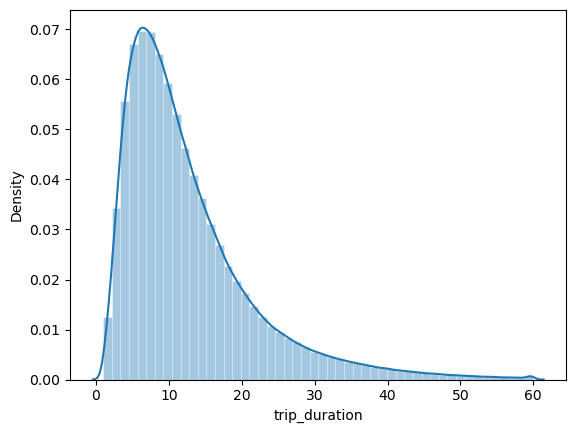

In [9]:
#visualizing target feature
sb.histplot(data['trip_duration'],kde=True,stat="density",
            kde_kws=dict(cut=3), bins=50,alpha=.4, edgecolor=(1, 1, 1, 0.4))

In [10]:
cat_data = data[['PULocationID','DOLocationID']].astype(str)
# numerical = ['trip_distance']
cat_data.dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [32]:
#encoding the categorical features
train_dicts = cat_data.to_dict(orient='records')

dv = DictVectorizer()
x = dv.fit_transform(train_dicts)
print(x.shape)

y = data['trip_duration'].values

#splitting dataset into training and testing sets
X_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1)


#instantiating and applying an OLS regression model

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(x_test)

mean_squared_error(y_test, y_pred, squared=False)


(2421440, 515)


6.991744677296059

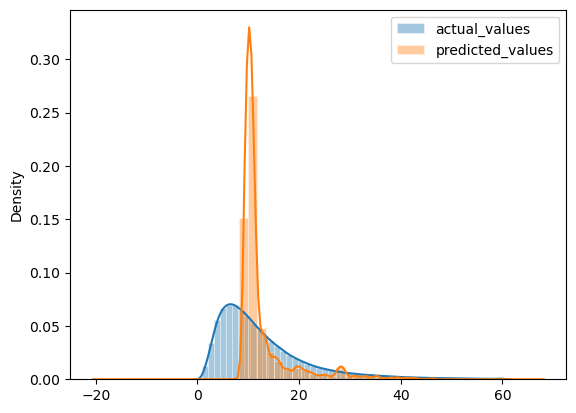

In [12]:
sb.histplot(y_train,label="actual_values",kde=True,stat="density",
            kde_kws=dict(cut=3), bins=50,alpha=.4, edgecolor=(1, 1, 1, 0.4))
sb.histplot(y_pred,label="predicted_values",kde=True,stat="density",
            kde_kws=dict(cut=3), bins=50,alpha=.4, edgecolor=(1, 1, 1, 0.4))
plt.legend()

In [13]:
print(model.score(x_test,y_pred))

1.0


In [14]:
#Lasso Regression
lmod = Lasso()
lmod.fit(X_train,y_train)

pred2 = lmod.predict(x_test)

print(f'mean squared error score:', mean_squared_error(y_test, pred2, squared=False))
print(f'model score:',lmod.score(x_test,pred2))


mean squared error score: 8.983934916752798
model score: 1.0


In [15]:
#Ridge Regression
rmod = Ridge()
rmod.fit(X_train,y_train)

pred3 = rmod.predict(x_test)

print(f'mean squared error score:',mean_squared_error(y_test, pred3, squared=False))
print(f'mean squared error score:',lmod.score(x_test,pred3))


mean squared error score: 6.990998703502108
mean squared error score: -2.012434101805738e-06


In [19]:
#read in dataset
data2 = pd.read_parquet('data_files/yellow_tripdata_2022-02.parquet')
data2.shape

(2979431, 19)

In [20]:
#feature engineering 
data2['trip_duration'] = data2.tpep_dropoff_datetime - data2.tpep_pickup_datetime #creating the duration feature
data2['trip_duration'] = data2.trip_duration.apply(lambda x: x.total_seconds()/60)# converting the feature to seconds


In [21]:
data2 = data2[(data2['trip_duration'] >= 1) & (data2['trip_duration'] <= 60)] #filterign data set by duration 

In [22]:
data2

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.0,5.40,1.0,N,138,252,1,17.00,1.75,0.5,3.90,0.00,0.3,23.45,0.0,1.25,12.433333
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.0,6.40,1.0,N,138,41,2,21.00,1.75,0.5,0.00,6.55,0.3,30.10,0.0,1.25,17.550000
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.0,12.50,1.0,N,138,200,2,35.50,1.75,0.5,0.00,6.55,0.3,44.60,0.0,1.25,23.650000
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.0,9.88,1.0,N,239,200,2,28.00,0.50,0.5,0.00,3.00,0.3,34.80,2.5,0.00,20.083333
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.0,12.16,1.0,N,138,125,1,35.50,0.50,0.5,8.11,0.00,0.3,48.66,2.5,1.25,26.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2979426,2,2022-02-28 23:50:00,2022-03-01 00:06:00,NaN,3.40,NaN,None,163,193,0,14.37,0.00,0.5,0.00,0.00,0.3,17.67,NaN,NaN,16.000000
2979427,2,2022-02-28 23:06:57,2022-02-28 23:19:12,NaN,3.48,NaN,None,141,4,0,14.51,0.00,0.5,2.00,0.00,0.3,19.81,NaN,NaN,12.250000
2979428,2,2022-02-28 23:48:13,2022-03-01 00:03:33,NaN,3.05,NaN,None,161,151,0,14.38,0.00,0.5,3.81,0.00,0.3,21.49,NaN,NaN,15.333333
2979429,2,2022-02-28 23:56:41,2022-03-01 00:04:57,NaN,2.62,NaN,None,141,226,0,12.53,0.00,0.5,1.71,0.00,0.3,17.54,NaN,NaN,8.266667


In [23]:
# define categorical features
cat_data2 = data2[['PULocationID','DOLocationID']].astype(str)

In [24]:
# turn the categorical columns into a list of dictionaries
val_dicts = cat_data2.to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)

In [25]:
# define target variable and assign to y_val
target = 'trip_duration'
y_train = data2[target].values
y_val = data2[target].values

In [26]:
# instantiate & fit our model
lr = LinearRegression()
lr.fit(X_val,y_train)

LinearRegression()

In [27]:
# Get predictions for the VALIDATION set
y_pred = lr.predict(X_val)
# calculate RMSE
mean_squared_error(y_val, y_pred, squared=False) # squared = False so this is root MSE (RMSE)

7.639501159978004

### PRODUCTIONIZING CODE

In [28]:
# Serializing the best model for subsequent and easy usage
with open('model.pkl', 'wb') as file:
    joblib.dump(model, file)